# Functional Encryption - Classification and information leakage
 
 
We have seen in Part 8 that we could build a distinguisher per digit but that it couldn't have an accuracy exceeding 59%. In this setting, recall that the defender learn on a dataset which mixes digits while the adversary can have a dataset with the same digit on all items in order to specialize more on the discintion task.

This task of character recognition is just an example of applying Function Encryption, but in this particular setting we can actually envision a more sophisticated attack by repetition. Indeed, in practice an adversary might want to detect the font used to write an encrypted text or at least a word. To do this, it could split the text into letters and try to predict the font on each of them, and make a majority vote. The intuition is that this process could reinforce its accuracy.

Let's try this!

# 10. Sequence distinguisher


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import show_results
# We now import from the collateral module
from learn import collateral

In [3]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10 #50
        self.new_adversary_epochs = 50
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

In [4]:
PRIVATE_OUTPUT_SIZE = 4
N_CHARS = 10
N_FONTS = 2

## 8.1 Loading $Q$ with resistance

In [5]:
class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 40)
        self.diag1 = nn.Linear(40, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- Junction
        self.jct = nn.Linear(PRIVATE_OUTPUT_SIZE, 784)

        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)

        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

We use the same $Q$ than in part 8

In [6]:
path = '../data/models/quadconvnet_part8.pt'
model = CollateralNet()
results = {}
model.load_state_dict(torch.load(path))
model.eval()

CollateralNet(
  (proj1): Linear(in_features=784, out_features=40, bias=True)
  (diag1): Linear(in_features=40, out_features=4, bias=False)
  (lin1): Linear(in_features=4, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=10, bias=True)
  (jct): Linear(in_features=4, out_features=784, bias=True)
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)

In [120]:
def sequential_test(args, model, test_loader, new_adversary):
    """
    Perform a normal test phase but separate predictions based on
    the true font label to predict. Make batch of items of the same
    font to simulate word, look at associated font prediction and
    do a majority font to predict the font used for the word.
    """
    model.eval()
    correct_char = 0
    correct_font = 0
    
    dict_fonts = {0: [], 1: []}
    
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]
            
            # Char evaluation
            if not new_adversary:
                output = model.forward_char(data)
                pred = output.argmax(1, keepdim=True)
                correct_char += pred.eq(target_char.view_as(pred)).sum().item()

            # Font evaluation
            if not new_adversary:
                output = model.forward_font(data)
            else:
                output = model.forward_adv_font(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()
            
            for label, p in zip(target_font, pred):
                dict_fonts[label.item()].append(p)

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))
    
    
    accuracies = []
    all_pred = torch.stack(dict_fonts[0] + dict_fonts[1]).float()
    threshold = all_pred.mean()
    for word_size in range(1, 140):
        n_word_pred = 0
        n_good_pred = 0
        for font, predictions in dict_fonts.items():
            t = torch.stack(predictions).view(-1).float()
            t = t[:len(t)//word_size * word_size].reshape(word_size, -1)
            if font == 1:
                n_word_pred += t.shape[1]
                n_good_pred += (torch.mean(t, dim=0) > threshold).float().sum()
            elif font == 0:
                n_word_pred += t.shape[1]
                n_good_pred += (torch.mean(t, dim=0) < threshold).float().sum()

        acc = n_good_pred / n_word_pred
        accuracies.append(acc)

    return acc_char, acc_font, accuracies

## 8.2 Testing distinguishability against multiples nets

We load the `Q` net that we have thoroughly built and it will be given to our new network structure

In [8]:
quadratic_model = model
quadratic_model.freeze('quad')

We now perform only the last phase with the new adversary, note that we change the data loader

In [9]:
fonts = ['cursive', 'Georgia']
letter = "6"

def evaluate_resistance(model, alpha=0):
    args = Parser()
    
    train_loader, test_loader = collateral.data.get_collateral_data_loaders(args, *fonts, letter)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        initial_phase = False
        perturbate = False
        recover = True
        
        new_adversary = True
        
        collateral.train(
            args, model, train_loader, optimizer, epoch, alpha,
            initial_phase, perturbate, recover, new_adversary
        )
        #test_perf_char, test_perf_font = collateral.test(args, model, test_loader, new_adversary)
        test_perf_char, test_perf_font, accuracies = sequential_test(args, model, test_loader, new_adversary)
        
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)
        
    show_results({'Word length': accuracies}, title="Benefit of predicting on words")

    return test_perfs_char, test_perfs_font

Here is the basic structure of a network like those seen previously. There is a quadratic part which inherits from the `Q` loaded, and a method `conv_font` is left empty so that we can provide arbitrary adversary by inheriting from this `BaseNet`.

In [10]:
class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [11]:
resistance_reports = {}

### 6.2.1 Fully connected models 

Here we inherit from BaseNet and we only have to specify `conv_font` and declare the layers used.

In [12]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = PRIVATE_OUTPUT_SIZE
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        


----- [64, 32, 16, 8]
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.725932
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.719745
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.690807
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690494

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5203/10000 (52.03%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693230
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.687961
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.690557
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.692984

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5218/10000 (52.18%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694211
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.695974
Train Epoch: 3

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.708991
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.703793
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.698714

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5356/10000 (53.56%)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.675842
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.682137
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.684278
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.679445

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5356/10000 (53.56%)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687707
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.696918
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.669526
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.696

Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.693196
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690581

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5451/10000 (54.51%)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692736
Train Epoch: 44 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.708349
Train Epoch: 44 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.678325
Train Epoch: 44 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.701301

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5446/10000 (54.46%)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.679721
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.677100
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.700089
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.683456

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 541

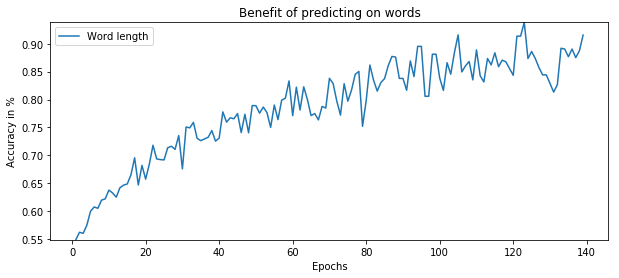


----- [32, 16, 8]
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691063
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.683661
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.694433
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.696705

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4906/10000 (49.06%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.699271
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.685877
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.688644
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.701663

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5243/10000 (52.43%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698266
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.700695
Train Epoch: 3 [38

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.711000
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.706794
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.699476

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5278/10000 (52.78%)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.674415
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.683020
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.686821
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.677351

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5292/10000 (52.92%)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683632
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.698114
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.665760
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690

Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.695953
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.691079

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5332/10000 (53.32%)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.702516
Train Epoch: 44 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.713979
Train Epoch: 44 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.687255
Train Epoch: 44 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.702680

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5353/10000 (53.53%)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685469
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.681138
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.698301
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690212

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 531

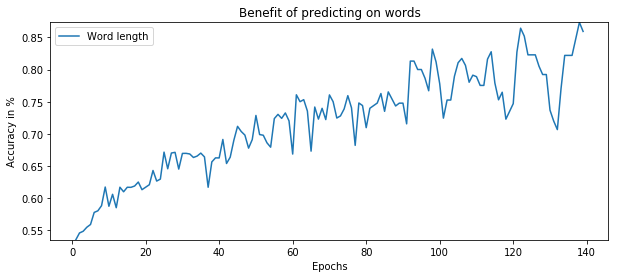


----- [24, 12]
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.800155
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.686270
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.699888
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.700415

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5053/10000 (50.53%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.705716
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.683663
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.685855
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.692460

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5174/10000 (51.74%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698912
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.702743
Train Epoch: 3 [38400

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.715779
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.706537
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.700827

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5311/10000 (53.11%)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.676401
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.690990
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.687264
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.672846

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5346/10000 (53.46%)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683067
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.699582
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.668900
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.693

Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.696259
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.691133

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5373/10000 (53.73%)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.701580
Train Epoch: 44 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.715733
Train Epoch: 44 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.673155
Train Epoch: 44 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.696608

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5409/10000 (54.09%)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685159
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.682770
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.702108
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.682016

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 533

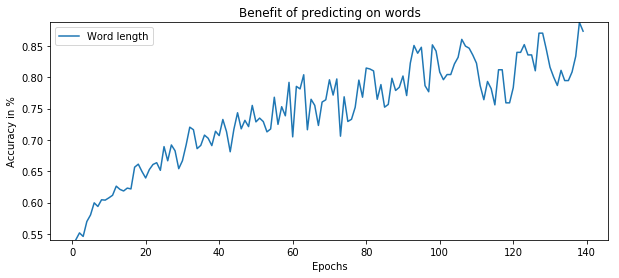


----- [64]
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.513206
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.667187
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.661789
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.746727

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5189/10000 (51.89%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.716885
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.663554
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.697796
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.698354

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5140/10000 (51.40%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.706824
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.708275
Train Epoch: 3 [38400/600

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.722045
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.701744
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.696721

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5478/10000 (54.78%)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.669491
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.652625
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.672598
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.696769

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5498/10000 (54.98%)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683557
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.675878
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.696052
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.680

Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.678065
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.683393

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5533/10000 (55.33%)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687754
Train Epoch: 44 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.703763
Train Epoch: 44 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.687092
Train Epoch: 44 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.677660

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5536/10000 (55.36%)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.675366
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.685369
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.703381
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.671441

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 557

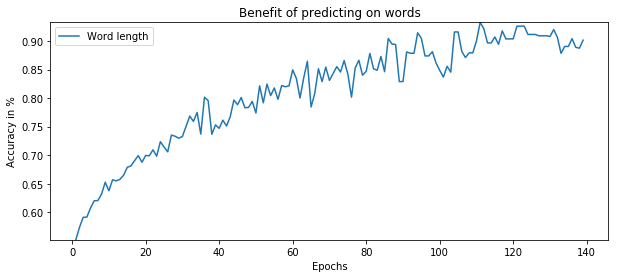


----- [32]
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.267406
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.709002
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.690740
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.725619

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5127/10000 (51.27%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697338
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.677499
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.684776
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.695100

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5146/10000 (51.46%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688822
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.707235
Train Epoch: 3 [38400/600

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.702951
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.696050
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.692735

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5344/10000 (53.44%)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.672184
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.658060
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.681853
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.682014

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5333/10000 (53.33%)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.676171
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.696037
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.687899
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.678

Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.681357
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.682240

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5389/10000 (53.89%)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689957
Train Epoch: 44 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.708069
Train Epoch: 44 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.679960
Train Epoch: 44 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.676941

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5540/10000 (55.40%)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.676076
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.688009
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.702708
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.681833

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 551

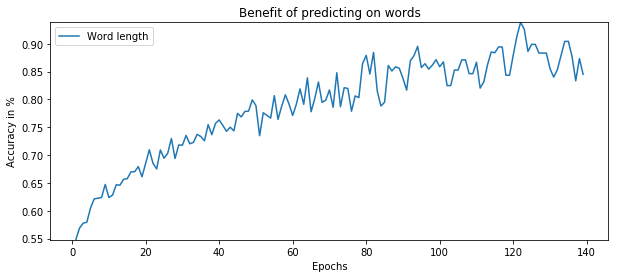


----- [16]
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.842519
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.692979
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.695085
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.715259

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5145/10000 (51.45%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.703034
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.666853
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.678890
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690959

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5239/10000 (52.39%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690199
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.709991
Train Epoch: 3 [38400/600

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.714554
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.711439
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.696285

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5349/10000 (53.49%)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681908
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.667628
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.689562
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.679884

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5431/10000 (54.31%)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678965
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.692309
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.682862
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.695

Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.683922
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.698492

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5393/10000 (53.93%)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.702072
Train Epoch: 44 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.726925
Train Epoch: 44 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.677058
Train Epoch: 44 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.688007

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5475/10000 (54.75%)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680124
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.683747
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.698893
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.680066

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 541

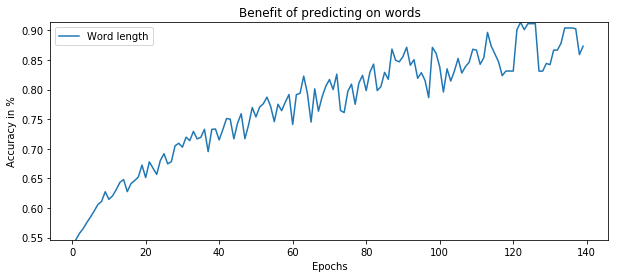

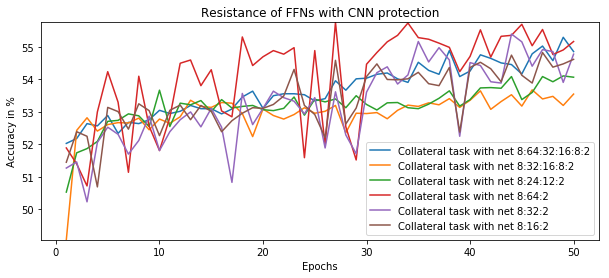

In [13]:
architectures = [[64, 32, 16, 8], [32, 16, 8], [24, 12], [64], [32], [16]]

for architecture in architectures:
    print('\n-----', architecture)
    model = FFNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    architecture = ':'.join(map(str, [8] + architecture + [N_FONTS]))
    resistance_reports[f"Collateral task with net {architecture}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of FFNs with CNN protection")


### 6.2.2 CNN models

In [14]:
class CNNet(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet, self).__init__(quadratic_model)
        # --- CNNs for font families
        self.nn_modules = nn_modules
        setattr(self, "net_0", nn.Linear(PRIVATE_OUTPUT_SIZE, 784))
        for i_layer, nn_module in enumerate(nn_modules):
            setattr(self, f"net_{i_layer + 1}", nn_module)
    
    def conv_font(self, x):
        switched_from_conv_lin = False
        out_channels = []
        # Make the junction
        linear = getattr(self, "net_0")  
        x = linear(x)
        x = x.view(-1, 1, 28, 28)
        # --- CNN
        for i_layer, _ in enumerate(self.nn_modules):
            layer = getattr(self, f"net_{i_layer + 1}")
            if isinstance(layer, nn.Conv2d): # Conv layer
                x = F.relu(layer(x))
                x = F.max_pool2d(x, 2, 2)
                out_channels.append(layer.out_channels)
            else: # Linear layer
                if not switched_from_conv_lin:
                    x = x.view(-1, 4*4*out_channels[-1])
                    switched_from_conv_lin = True
                if i_layer < len(self.nn_modules) - 1:
                    x = F.relu(layer(x))
                else:
                    x = layer(x)
        return x
         

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.737383
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.686792
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.699538
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.697333

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5273/10000 (52.73%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.708966
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.673391
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.684481
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.688753

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5417/10000 (54.17%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690855
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.706696
Train Epoch: 3 [38400/60000 (64%)]	Lo

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.708913
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.706776
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690521

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5536/10000 (55.36%)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.644197
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.661424
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.672639
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690979

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5562/10000 (55.62%)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691504
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.669028
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.704222
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.673

Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.682993
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.677889

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5588/10000 (55.88%)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681940
Train Epoch: 44 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.698207
Train Epoch: 44 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.687756
Train Epoch: 44 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.670866

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5604/10000 (56.04%)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.674212
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.681975
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.708637
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.665585

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 561

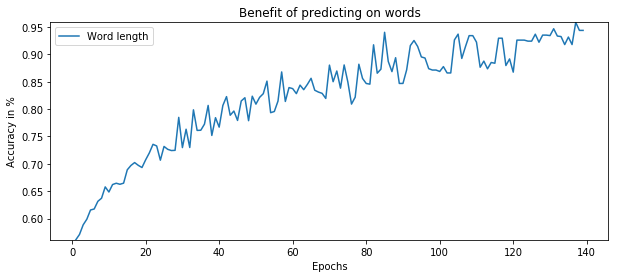

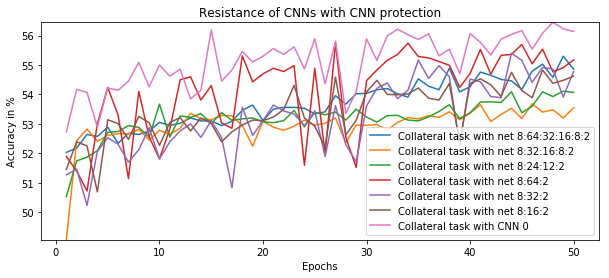

In [15]:
architectures = [
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 500),
        nn.Linear(500, N_FONTS)
    )
]
"""
,
    (
        nn.Conv2d(1, 30, 4, 1),
        nn.Conv2d(30, 100, 4),
        nn.Linear(100 * 4 * 4, 1000),
        nn.Linear(1000, 100),
        nn.Linear(100, N_FONTS)
    )
"""
for i, architecture in enumerate(architectures):
    model = CNNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    resistance_reports[f"Collateral task with CNN {i}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of CNNs with CNN protection")

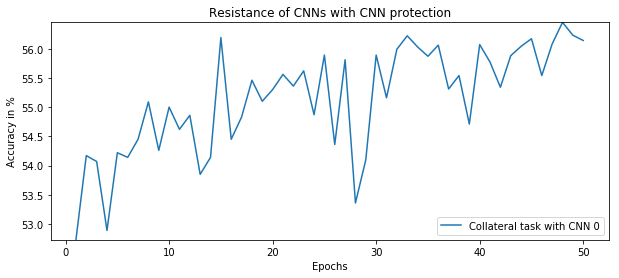

In [16]:
show_results(
    {k:v for k, v in resistance_reports.items() if 'CNN' in k}, 
    title="Resistance of CNNs with CNN protection"
)

## 6.3 Non-NN models

We now test many models from the sklearn library

### Data preparation

In [17]:
transform = BaseNet(quadratic_model)

In [18]:
def get_input_onehot_labels(dataset, label="font", one_hot=True):
    data_input = dataset.tensors[0]
    label_idx = {'char': 0, 'font': 1}[label]
    label_size = {'char': N_CHARS, 'font': N_FONTS}[label]
    labels = dataset.tensors[1][:, label_idx].view(-1, 1)
    
    data_label_onehot = torch.zeros(len(labels), label_size)
    data_label_onehot.scatter_(1, labels, 1)
    
    return data_input, labels, data_label_onehot
    

Get dataset and transform in one hot vector

In [19]:
train_dataset, test_dataset = collateral.data.get_datasets(None, None)
train_input, train_label, train_label_one_hot = get_input_onehot_labels(train_dataset, label="font")
test_input, test_label, test_label_one_hot = get_input_onehot_labels(test_dataset, label="font")

Training set 60000 items
Testing set  10000 items


Apply the quadratic model transformation

In [20]:
train_input = transform.quad(train_input).detach().numpy()
test_input = transform.quad(test_input).detach().numpy()

In [21]:
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

In [22]:
train_input.shape, train_label.shape

((60000, 4), torch.Size([60000]))

In [23]:
ALL = train_input.shape[0]
CPOWER = 'LOW'

In [24]:
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import svm

In [88]:
def evaluate_sklearn(reg, one_hot=True, limit=int(10e10)):
    train_labels = {True: train_label_one_hot, False: train_label}[one_hot]
    reg.fit(train_input[:limit], train_labels[:limit].detach().numpy()) 
    output = reg.predict(test_input)
    if one_hot:
        pred = torch.tensor(output).argmax(1, keepdim=True)
    else:
        if isinstance(output, list):
            pred = torch.tensor(list(map(round, output))).long().view(-1, 1)
        else:
            pred = torch.tensor(np.round(output)).long().view(-1, 1)
    y = test_label.view_as(pred)
    acc = pred.eq(y).sum().item() / len(pred)
    
    dict_fonts = {0: [], 1: []}
    for label, p in zip(test_label, pred):
        dict_fonts[label.item()].append(p)
    word_accuracies = []
    all_pred = torch.stack(dict_fonts[0] + dict_fonts[1]).float()
    threshold = all_pred.mean()
    for word_size in range(1, 140):
        n_word_pred = 0
        n_good_pred = 0
        for font, predictions in dict_fonts.items():
            t = torch.stack(predictions).view(-1).float()
            t = t[:len(t)//word_size * word_size].reshape(word_size, -1)
            if font == 1:
                n_word_pred += t.shape[1]
                n_good_pred += (torch.mean(t, dim=0) > threshold).float().sum()
            elif font == 0:
                n_word_pred += t.shape[1]
                n_good_pred += (torch.mean(t, dim=0) < threshold).float().sum()

        word_accuracies.append(n_good_pred / n_word_pred)
        
        
    show_results({'Word length': word_accuracies}, title="Benefit of predicting on words")
        
    return acc

### Linear models

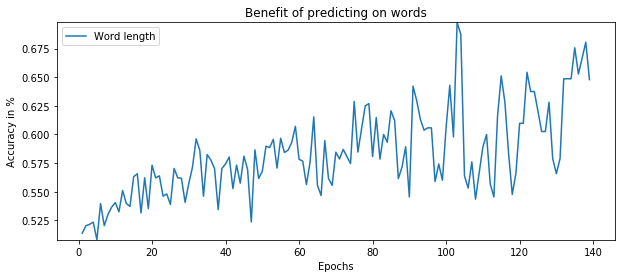

0.5137


In [106]:
reg = linear_model.Ridge(alpha=.9)
acc = evaluate_sklearn(reg, limit=1000)
print(acc)
resistance_reports['linear model Ridge'] = acc * 100

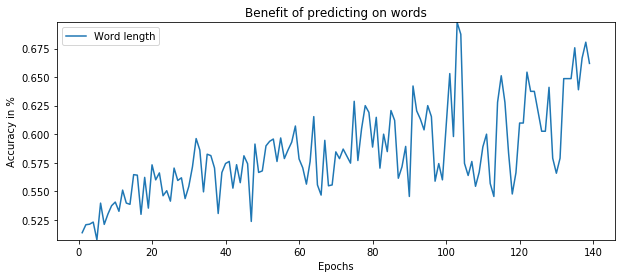

0.5137


In [103]:
reg = linear_model.RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100], cv=5)
acc = evaluate_sklearn(reg, limit=1000)
print(acc)

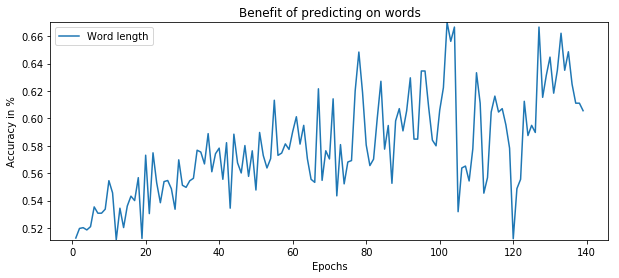

0.5127


In [94]:
reg = linear_model.Lasso(alpha=0.1)
acc = evaluate_sklearn(reg, limit=1000)
print(acc)
resistance_reports['linear model Lasso'] = acc * 100

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=tensor(0.), top=tensor(0.)
  ret = ax.set_ylim(*args, **kwargs)


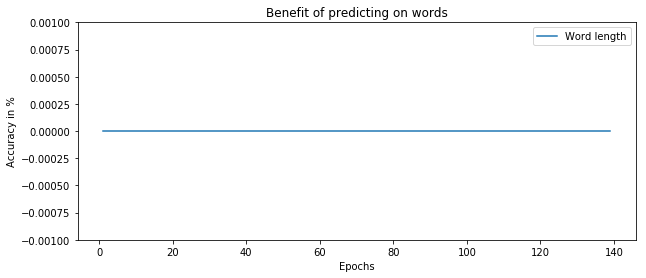

0.4995


In [107]:
reg = linear_model.LassoLars(alpha=0.1)
acc = evaluate_sklearn(reg, limit=1000)
print(acc)

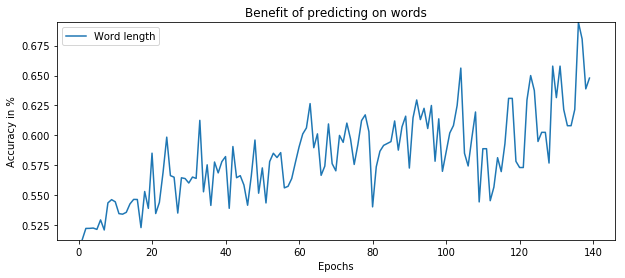

0.5128


In [114]:
reg = linear_model.BayesianRidge()
acc = evaluate_sklearn(reg, one_hot=False, limit=1000)
print(acc)

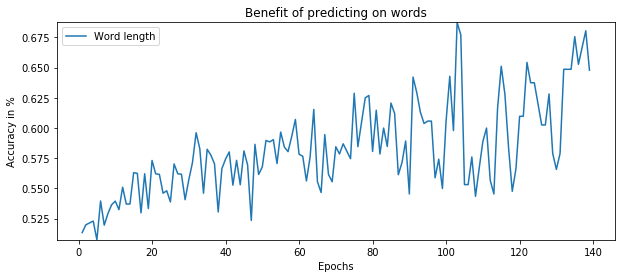

0.5135


In [101]:
reg = linear_model.LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial', max_iter=1000)
acc = evaluate_sklearn(reg, one_hot=False, limit=1000)
print(acc)
resistance_reports['logistic regression'] = acc * 100

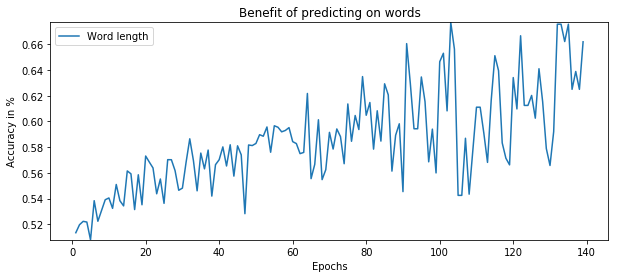

0.5135


In [102]:
reg = linear_model.LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial')
acc = evaluate_sklearn(reg, one_hot=False, limit=1000)
print(acc)

### Quadratic Discriminant Analysis

In [33]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

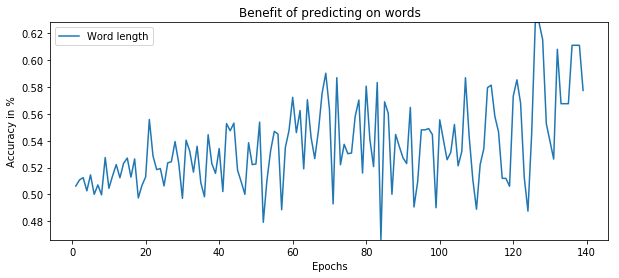

0.5062


In [115]:
clf = QuadraticDiscriminantAnalysis()
acc = evaluate_sklearn(clf, one_hot=False, limit=1000)
print(acc)
resistance_reports['Quadratic Discriminant Analysis'] = acc * 100

### Kernel Ridge

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=3.75172e-09): result may not be accurate.
  overwrite_a=False)


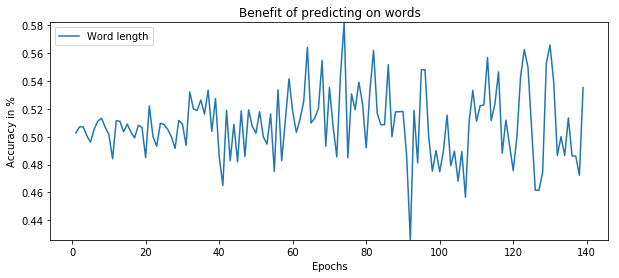

0.5026


In [117]:
clf = kernel_ridge.KernelRidge(alpha=1.0)
limit = {'LOW': 15000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

### SVM

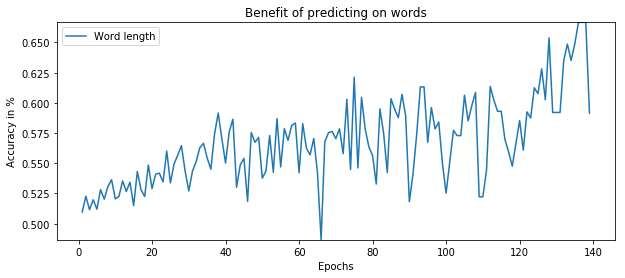

0.5097


In [63]:
clf = svm.SVC(gamma='scale', kernel='linear')
limit = {'LOW': 1000, 'MEDIUM': 15000, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])

print(acc)

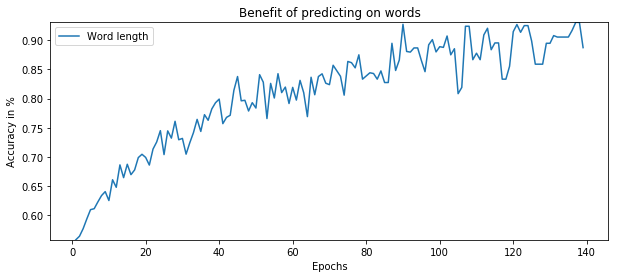

0.5584


In [37]:
clf = svm.SVC(gamma='scale', kernel='rbf')
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)
resistance_reports['SVM (rbf)'] = acc * 100

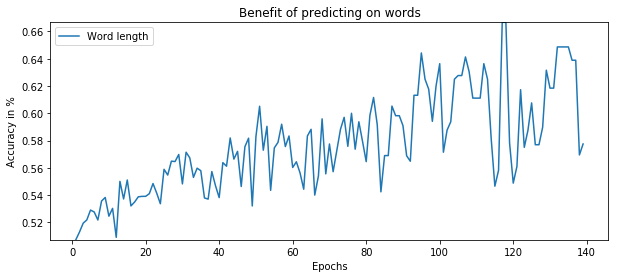

0.5072


In [38]:
clf = svm.SVC(gamma='scale', kernel='poly', coef0=0)
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

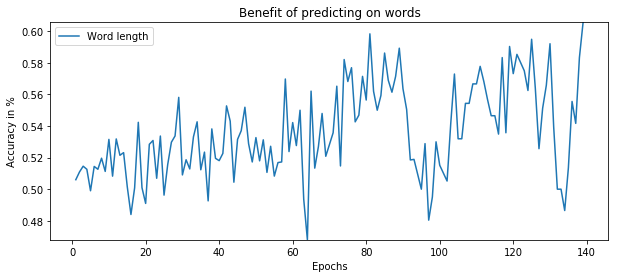

0.506


In [39]:
clf = svm.SVC(gamma='scale', kernel='sigmoid', coef0=0)
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

### Stochastic gradient Descent

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


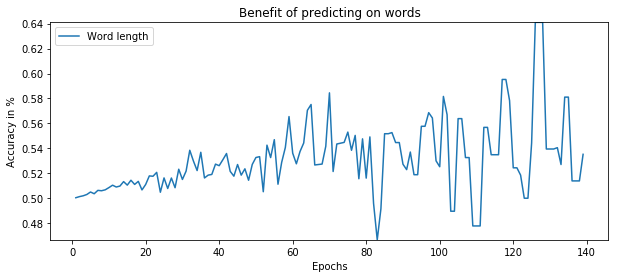

0.5004


In [40]:
clf = linear_model.SGDClassifier(loss="hinge", penalty="l2")
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['SGDClassifier'] = acc * 100

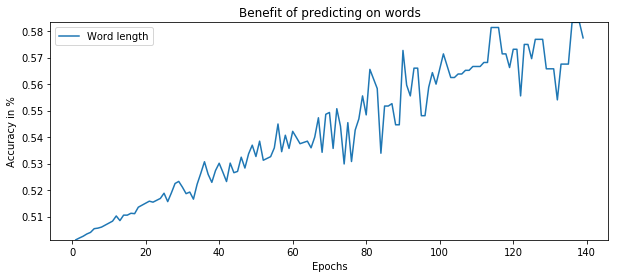

0.5012


In [41]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss="log")
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

### K-Neighbors Classifier

In [42]:
from sklearn.neighbors import KNeighborsClassifier

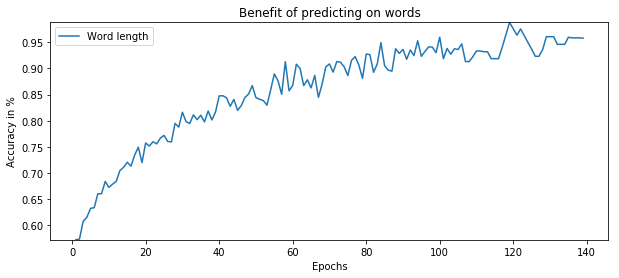

0.5725


In [43]:
clf = KNeighborsClassifier(n_neighbors=7)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['K-Neighbors Classifier'] = acc * 100

### Gaussian process (not scalable)

In [44]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

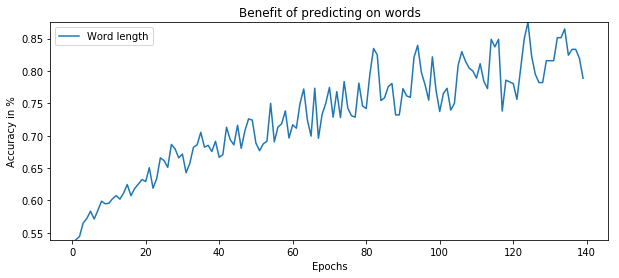

0.5393


In [68]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0)
limit = {'LOW': 1100, 'MEDIUM': 5000, 'HIGH': 20000}
acc = evaluate_sklearn(gpc, one_hot=False, limit=limit[CPOWER])
print(acc)
resistance_reports['Gaussian process'] = acc * 100

### Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB

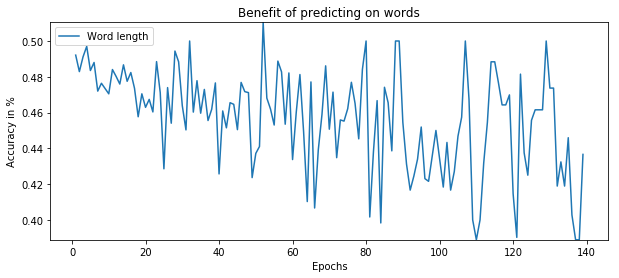

0.4921


In [69]:
gnb = GaussianNB()
acc = evaluate_sklearn(gnb, one_hot=False)
print(acc)

### Decision Tree Classifier

In [48]:
from sklearn.tree import DecisionTreeClassifier

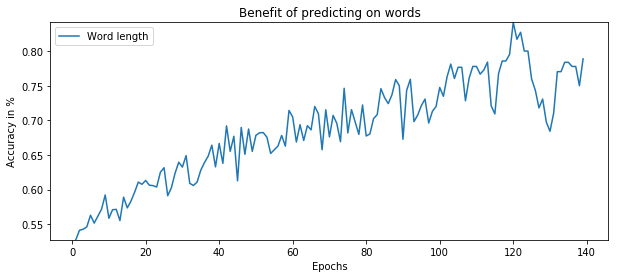

0.5275


In [49]:

clf = DecisionTreeClassifier(max_depth=5)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

resistance_reports['Decision Tree Classifier'] = acc * 100

### Ensemble methods

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

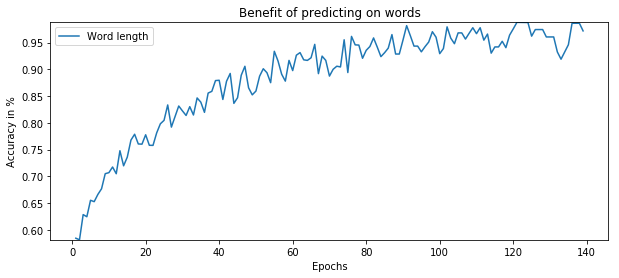

0.5841


In [51]:
clf = RandomForestClassifier(max_depth=30, n_estimators=100, max_features=4)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Random Forest Classifier'] = acc * 100

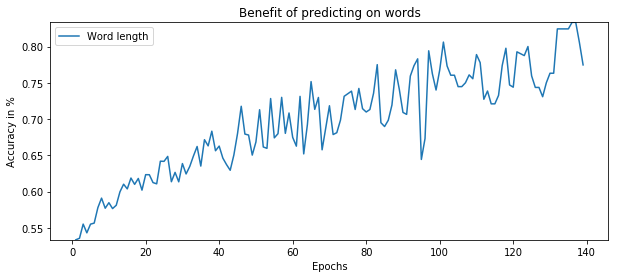

0.5334


In [52]:
clf = AdaBoostClassifier(n_estimators=200, learning_rate=1.)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['AdaBoost Classifier'] = acc * 100

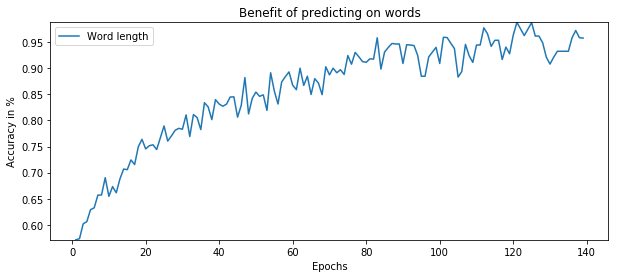

0.5714


In [53]:
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=10, random_state=0)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Gradient Boosting Classifier'] = acc * 100

### (sklearn) Neural Network

In [54]:
from sklearn.neural_network import MLPClassifier

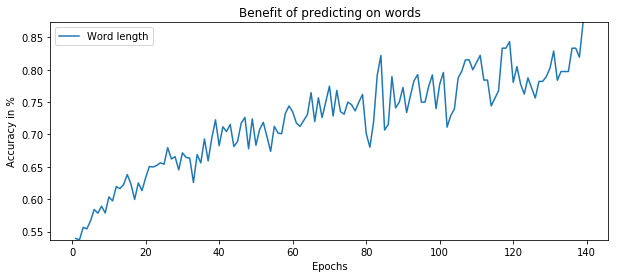

0.5393


In [55]:
clf = MLPClassifier(solver='lbfgs', alpha=1,
                    hidden_layer_sizes=(10, 40, 10), random_state=1)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

## Summary

In [56]:
def print_table(results):
    n_cols = 2
    title_length = 0
    for title in results.keys():
        title_length = max(title_length, len(title))
    result_length = 8
    table_length = 1 + n_cols + title_length + result_length
    sep = '+'.join(
        ['', '-'*title_length, '-'*result_length, '']
    )
    for title, serie in results.items():
        print(sep)
        title = (title + ' '*title_length)[:title_length]
        if isinstance(serie, list):
            result = round(np.mean(serie[-4:]), 2)
        else:
            result = round(serie, 2)
        result = (' ' +str(result) + '%' + ' '*result_length)[:result_length]
        line = '|'.join(
            ['', title, result, '']
        )
        print(line)
    print(sep)

## Conclusion

As you can observe, the collateral accuracy gets dramatically high when the number of characters tested from the same text increases, and this even for models which were performing really bad on a single character.

However, this is a shortcoming of our example and not of the technique we proposed for sabotaging collateral Learning. It wouldn't work for example if our network was given as an output images of words or texts.